In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import datetime
import scipy
import numpy as np
from scipy.stats import norm

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

<script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window.Plotly) {{require(['plotly'],function(plotly) {window.Plotly=plotly;});}}</script>

In [3]:
params = pd.read_csv('params.csv')
email_data = pd.read_csv('email_data.csv')
orders = pd.read_csv('orders.csv')


print(params['id'].unique().shape)
print(email_data['id'].unique().shape)
print(orders['id'].unique().shape)

(1307992,)
(265736,)
(27149,)


# Data Cleaning / Transformation
Within our data, we have roughly 1.3 M unique customer ID's in the params set, 265K emailed customers,resulting int 27K unique customers who made orders over our campaign timeperiod of one month. 

Here we clean our data in the following ways:

- We remove orders from the small time period prior to our email data being sent. This helps us isolate our time period for analysis / modeling

- Remove ID's where we don't have order_count in our params table, blank lifetime revenue, missing first/last order date, or missing additional orders in our time period

- One particular ID seems to have roughly 900 email open events, this seems to be an outlier and was removed for now

Merging / Modeling features

- All three datasets are merged based on unique ID's in the email set. 
- Order count and Revenue are combined features from the order set
- We create email click/open event features which are count values per unique customer ID
- we used past t/f values and historical revenue to round out or features used for modeling

In [5]:
# Individual Data Set Transformations

email_data['event_time_ts'] = email_data['event_time'].apply(datetime.datetime.fromtimestamp)
email_data['event_time_date'] = email_data['event_time_ts'].dt.date

orders['event_time_ts'] = orders['event_time'].apply(datetime.datetime.fromtimestamp)
orders['event_time_weekday'] = orders['event_time_ts'].apply(datetime.datetime.weekday)
orders['event_time_hour'] = orders['event_time_ts'].dt.hour
orders['event_time_date'] = orders['event_time_ts'].dt.date

print(orders['event_time_ts'].min(), orders['event_time_ts'].max())
print(email_data['event_time_ts'].min(), email_data['event_time_ts'].max())

orders = orders[orders['event_time_ts'] > email_data['event_time_ts'].min()]

2017-04-21 19:00:27 2017-05-21 18:58:50
2017-04-25 14:00:51 2017-05-21 18:56:04


In [5]:
# Merge/Clean Data for Modeling / EDA

d = {'id': email_data['id'].unique()}
engagement = pd.DataFrame(data = d)

# Params Features
for i in email_data['event_type'].unique():
    df = email_data[email_data['event_type'] == i][['id', 'event_type']].groupby(['id']).count().reset_index()
    engagement = engagement.merge(df, how='left',on='id')
    engagement = engagement.rename(index=str, columns={"event_type": i})

engagement = engagement.fillna(0)
engagement = engagement.merge(params, how='left',on='id')

engagement['has_purchased_widget'] = engagement['has_purchased_widget'].fillna('f')
engagement['has_purchased_trinket'] = engagement['has_purchased_trinket'].fillna('f')
engagement['has_purchased_gizmo'] = engagement['has_purchased_gizmo'].fillna('f')

# Orders Data
engagement = engagement.merge(orders[['id', 'revenue']].groupby(['id']).sum().reset_index(), how='left',on='id')
engagement = engagement.merge(orders[['id', 'revenue']].groupby(['id']).count().reset_index(), how='left',on='id')
engagement = engagement.rename(index=str, columns={"revenue_x": 'Revenue_Sum'})
engagement['Revenue_Sum'] = engagement['Revenue_Sum'].fillna(0)
engagement = engagement.rename(index=str, columns={"revenue_y": 'Order_Count'})
engagement['Order_Count'] = engagement['Order_Count'].fillna(0)

for i in orders['product'].unique():
    df = orders[orders['product'] == i][['id', 'revenue']].groupby(['id']).sum().reset_index()
    engagement = engagement.merge(df, how='left',on='id')
    engagement = engagement.rename(index=str, columns={"revenue": i+"-rev"})
    engagement[i+"-rev"] = engagement[i+"-rev"].fillna(0)
    
engagement = engagement.dropna(subset=['order_count', 'first_order_date', 'last_order_date'], thresh=2)
engagement = engagement.dropna(subset=['lifetime_revenue'], thresh=1)
engagement = engagement[engagement.email_open < 900]
engagement['email_events_total'] = engagement['email_open'] + engagement['email_click']
engagement['email_interaction'] = np.where(engagement['email_events_total']>1,1,0)
engagement['first_order_date_ts'] = engagement['first_order_date'].apply(datetime.datetime.fromtimestamp)
engagement['days_since_first'] = (email_data['event_time_ts'].min() - engagement['first_order_date_ts']).dt.days

print(engagement.isnull().sum().sum(), ' Nulls / NaNs')
print(engagement.shape)

0  Nulls / NaNs
(265656, 21)


# Exploring the Campaign Data

below we plot some of the important relationships in the timeperiod.

- first and foremost we found having purchased widget prior (=t) seems to result in more interaction with email marketing and increased revenue over the time period

- Past lifetime revenue was an important predictor of spend in the time period

- We see a spike in revenue during the first week after emails are sent. This corresponds with engagement in the email materials. Trinket and Widget sales see the largest move in revenue per day rate

- Higher mean revenue per emailed recipient over the time period where there is a prior purchase of widget (Prior Widget T vs F). This is statistically significant with t-stat of ~ 8 and p ~ 0.00

- Targeting those who had purchased Widget, Trinket or Both had higher probabilities of resulting in an order. Order rates for Both seem to be the highest.  

- This leads us to recommend targeting highest lifetime revenue clients who have purchased both widget and trinket. 


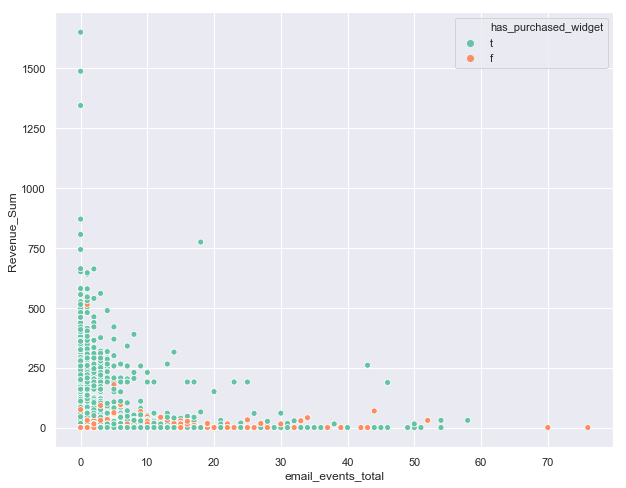

In [159]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x="email_events_total", y="Revenue_Sum", hue='has_purchased_widget',
                data=engagement[engagement['email_events_total'] < 80], palette="Set2")

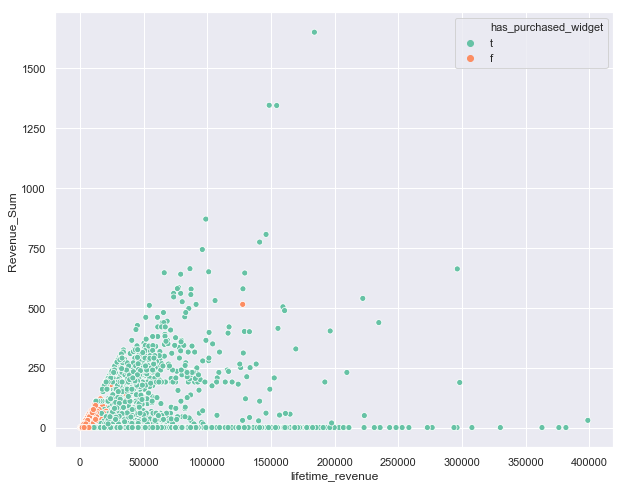

In [160]:
sns.scatterplot(x="lifetime_revenue", y="Revenue_Sum", hue='has_purchased_widget',
                data=engagement[engagement['lifetime_revenue'] < 400000], palette="Set2")

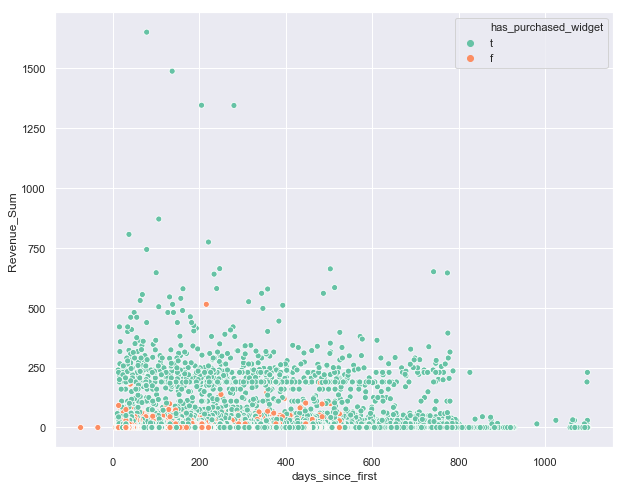

In [91]:
sns.scatterplot(x="days_since_first", y="Revenue_Sum", hue='has_purchased_widget',
                data=engagement, palette="Set2")

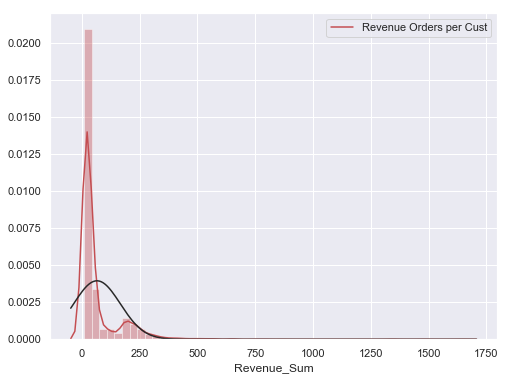

In [19]:
sns.set(rc={'figure.figsize':(8,6)})
sns.distplot(engagement[engagement['Revenue_Sum']>0]['Revenue_Sum'], color = 'r',
            kde_kws={"color": "r", "label": "Revenue Orders per Cust"},
            fit=norm)

Order Revenue appears to be lognormally distributed.

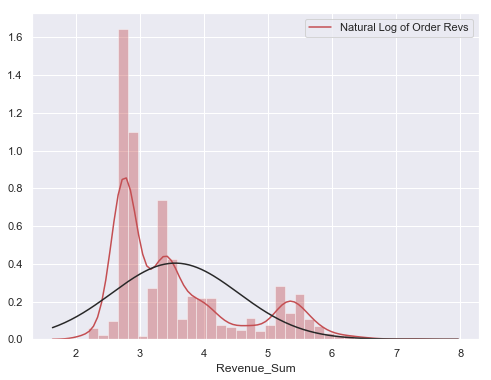

In [20]:
sns.distplot(np.log(engagement[engagement['Revenue_Sum']>0]['Revenue_Sum']), color = 'r',
            kde_kws={"color": "r", "label": "Natural Log of Order Revs"},
            fit=norm)

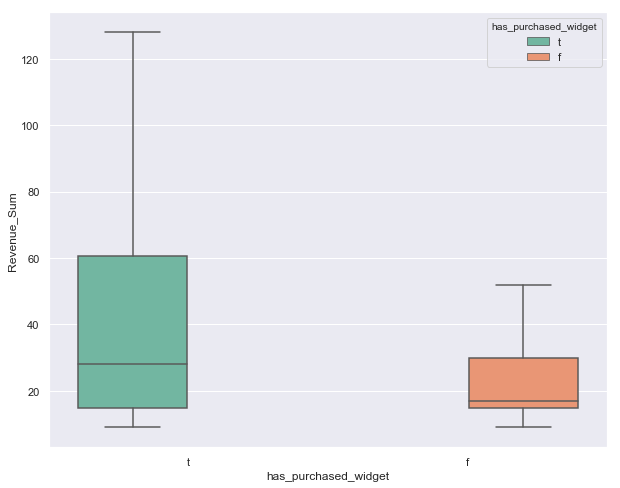

In [137]:
sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(x="has_purchased_widget", y='Revenue_Sum', 
                      data=engagement[engagement['Revenue_Sum']>0],
                      hue = 'has_purchased_widget',
                      palette="Set2",
                      showfliers=False)

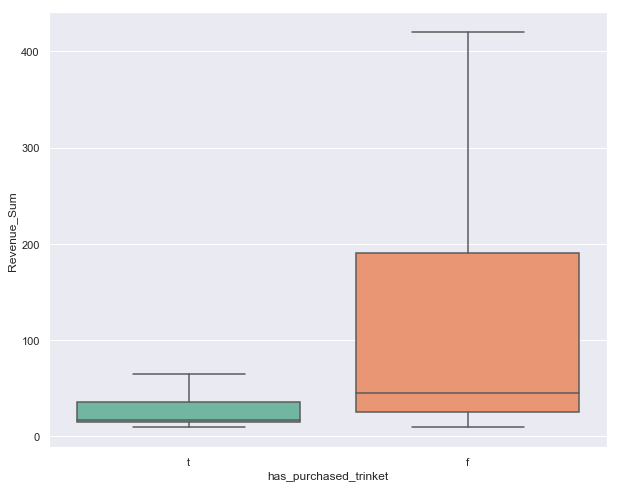

In [109]:
sns.set(rc={'figure.figsize':(10,8)})
sns.boxplot(x="has_purchased_trinket", y='Revenue_Sum', 
                      data=engagement[engagement['Revenue_Sum']>0],
                      palette="Set2",
                      showfliers=False)

In [104]:
df = engagement[['email_send', 'has_purchased_widget', 'has_purchased_trinket', 'email_interaction', 'Order_Count']
                ].groupby(['has_purchased_widget', 'has_purchased_trinket']).sum()

df['Order_Rate'] = df['Order_Count']/df['email_send']

df

<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>email_send</th>
      <th>email_interaction</th>
      <th>Order_Count</th>
      <th>Order_Rate</th>
    </tr>
    <tr>
      <th>has_purchased_widget</th>
      <th>has_purchased_trinket</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="2" valign="top">f</th>
      <th>f</th>
      <td>12869</td>
      <td>886</td>
      <td>130.0</td>
      <td>0.010102</td>
    </tr>
    <tr>
      <th>t</th>
      <td>34751</td>
      <td>2946</td>
      <td>1057.0</td>
      <td>0.030416</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">t</th>
      <th>f</th>
      <td>175227</td>
      <td>10752</td>
      <td>1455.0</td>
      <td>0.008304</td>
    </tr>
    <tr>
      <th>t</th>
      <td>42810</td>
      <td>4500</td>
      <td>3271.0</td>
      <td>0.076407</td>
    </tr>
  </tbody>
</table>
</div>

In [106]:
df = engagement[['email_send', 'has_purchased_widget', 'has_purchased_trinket', 'email_interaction', 'Order_Count']
                ].groupby(['has_purchased_widget', 'has_purchased_trinket', 'email_interaction']).sum()

df['Order_Rate'] = df['Order_Count']/df['email_send']

df

<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th></th>
      <th>email_send</th>
      <th>Order_Count</th>
      <th>Order_Rate</th>
    </tr>
    <tr>
      <th>has_purchased_widget</th>
      <th>has_purchased_trinket</th>
      <th>email_interaction</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="4" valign="top">f</th>
      <th rowspan="2" valign="top">f</th>
      <th>0</th>
      <td>11983</td>
      <td>91.0</td>
      <td>0.007594</td>
    </tr>
    <tr>
      <th>1</th>
      <td>886</td>
      <td>39.0</td>
      <td>0.044018</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">t</th>
      <th>0</th>
      <td>31804</td>
      <td>614.0</td>
      <td>0.019306</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2947</td>
      <td>443.0</td>
      <td>0.150322</td>
    </tr>
    <tr>
      <th rowspan="4" valign="top">t</th>
      <th rowspan="2" valign="top">f</th>
      <th>0</th>
      <td>164475</td>
      <td>1034.0</td>
      <td>0.006287</td>
    </tr>
    <tr>
      <th>1</th>
      <td>10752</td>
      <td>421.0</td>
      <td>0.039156</td>
    </tr>
    <tr>
      <th rowspan="2" valign="top">t</th>
      <th>0</th>
      <td>38310</td>
      <td>2135.0</td>
      <td>0.055730</td>
    </tr>
    <tr>
      <th>1</th>
      <td>4500</td>
      <td>1136.0</td>
      <td>0.252444</td>
    </tr>
  </tbody>
</table>
</div>

In [124]:
df = engagement[['id', 'email_send', 'has_purchased_widget', 'email_events_total', 'Revenue_Sum']
                ].groupby(['has_purchased_widget']).sum()
df['email_event_rate'] = df['email_events_total']/df['email_send']
df['Revenue_Avg'] = df['Revenue_Sum']/df['email_send']
df

,email_send,email_events_total,Revenue_Sum,email_event_rate,Revenue_Avg
has_purchased_widget,,,,,
f,47620,22454.0,31203.0,0.471525,0.655250
t,218037,86485.0,286753.0,0.396653,1.315158


In [17]:
t_test = scipy.stats.ttest_ind(engagement[engagement['has_purchased_widget'] == 't']['Revenue_Sum'],
                               engagement[engagement['has_purchased_widget'] == 'f']['Revenue_Sum'])

print('t-stat ', t_test [0], 'pval ', t_test [1])

t-stat  8.09012669273 pval  5.98507457975e-16


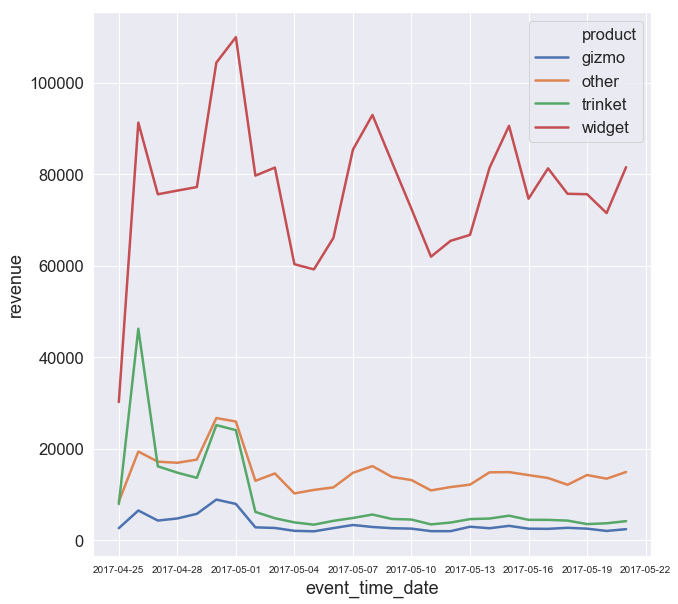

In [5]:
revs_by_day = orders[['product', 'event_time_date', 'revenue']].groupby(['product', 'event_time_date']).sum()
revs_by_day = revs_by_day.reset_index()

# In-Campaign Sales by Day
plt.rcParams["xtick.labelsize"] = 10
sns_plot = sns.lineplot(x="event_time_date", y="revenue",
                         hue="product",
                         data=revs_by_day)

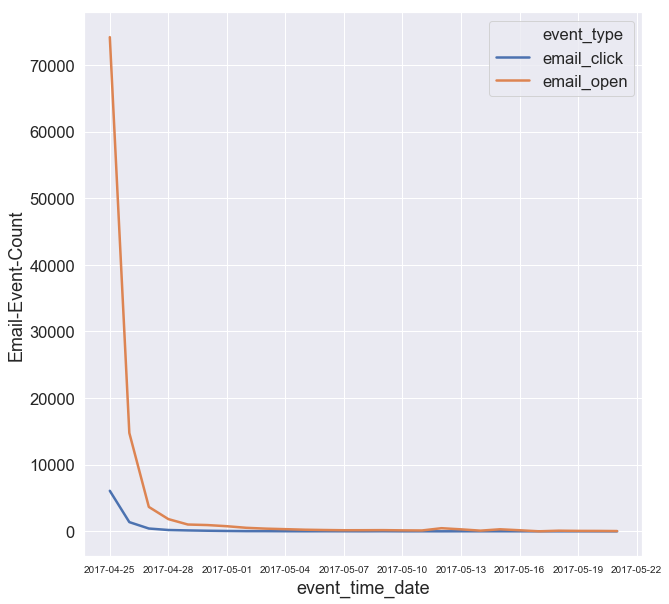

In [16]:
email_engage_by_day = email_data[['event_type', 'event_time_date', 'id']].groupby(['event_time_date', 'event_type']).count().reset_index()

email_engage_by_day = email_engage_by_day.rename(index=str, columns={"id": "Email-Event-Count"})

plt.rcParams["xtick.labelsize"] = 10
sns_plot = sns.lineplot(x="event_time_date", y="Email-Event-Count",
                        hue="event_type",
                        data=email_engage_by_day[email_engage_by_day['event_type'].isin(['email_click','email_open'])])

# Campaign Targeting / Improvement 

Though mostly covered in our last section, we cover targeting below from a statistical inference perspective:

- We fit two different types of models and inspect the output below, we use the entirety of our data for statistical inference

- Our first model is a logistic regression model trained on 0/1 order / did not order outcomes, we can see prior t orders had positive co-effecients that were statistically significant

- Our test statistics validate our targeting assumptions presented prior, we should target those who have purchased widget, gizmo, trinket or some combination

- Unfortunately given low recall rates, we should be relatively uncertain about exactly which of our targeted customers will respond to email marketing

- To combat class imbalance we use class weights in both our logistic regression & XGboosted trees. We test various class weights from 3 - 64. 

- Boosted Tree Models Predict positive orders on par with logistic regression, importance of lifetime revenue & email statistics come up as top three variables (use of scaled samples was particularly helpful here)

- Our boosted tree cross validation plot, tells logloss decline slows around 50 boosting
 rounds, though our CV logloss doesn't seem to rise even around 400 trees. We see ~ 50 boosted trees as being optimal to avoid overfitting.

- Revenue was more straight forward, here we try to model revenue amount by unique client using similar input variables 

- We found that our order revenue followed a log normal distribution, with log normal lifetime revenue explaining most of the variation in our order data, 

- IE higher lifetime Revenue lead to higher order revenue.   


In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import Logit, OLS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import xgboost as xgb


engagement['widget_b'] = np.where(engagement['has_purchased_widget'] == 't', 1, 0)
engagement['tinket_b'] = np.where(engagement['has_purchased_trinket'] == 't', 1, 0)
engagement['tinket_widget_b'] = engagement['widget_b']*engagement['tinket_b']
engagement['gizmo_b'] = np.where(engagement['has_purchased_gizmo'] == 't', 1, 0)
engagement['ln_lifetime_rev'] = np.log(engagement['lifetime_revenue'])

engagement['Order_b'] = np.where(engagement['Order_Count'] > 0, 1, 0)

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(engagement, test_size=0.3)

X = train[['email_open', 'email_click', 
                'widget_b', 'tinket_b', 'gizmo_b', 
                'ln_lifetime_rev']]

Y = train['Order_b']

X_test = test[['email_open', 'email_click', 
                'widget_b', 'tinket_b', 'gizmo_b', 
                'ln_lifetime_rev']]

Y_test = test['Order_b']

data_dmatrix = xgb.DMatrix(data=X,label=Y)

data_dmatrix_t = xgb.DMatrix(data=X_test,label=Y_test)

print(X.shape, Y.shape, X_test.shape, Y_test.shape)

(185959, 6) (185959,) (79697, 6) (79697,)


In [8]:
model = Logit(Y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.070602
         Iterations 9


<table class="simpletable">
<caption>Logit Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>      <td>Order_b</td>     <th>  No. Observations:  </th>  <td>185959</td> 
</tr>
<tr>
  <th>Model:</th>               <td>Logit</td>      <th>  Df Residuals:      </th>  <td>185953</td> 
</tr>
<tr>
  <th>Method:</th>               <td>MLE</td>       <th>  Df Model:          </th>  <td>     5</td> 
</tr>
<tr>
  <th>Date:</th>          <td>Sat, 05 Jan 2019</td> <th>  Pseudo R-squ.:     </th>  <td>0.1017</td> 
</tr>
<tr>
  <th>Time:</th>              <td>13:03:06</td>     <th>  Log-Likelihood:    </th> <td> -13129.</td>
</tr>
<tr>
  <th>converged:</th>           <td>True</td>       <th>  LL-Null:           </th> <td> -14615.</td>
</tr>
<tr>
  <th> </th>                      <td> </td>        <th>  LLR p-value:       </th>  <td> 0.000</td> 
</tr>
</table>
<table class="simpletable">
<tr>
         <td></td>            <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>email_open</th>      <td>    0.0992</td> <td>    0.008</td> <td>   12.091</td> <td> 0.000</td> <td>    0.083</td> <td>    0.115</td>
</tr>
<tr>
  <th>email_click</th>     <td>    1.3537</td> <td>    0.038</td> <td>   35.843</td> <td> 0.000</td> <td>    1.280</td> <td>    1.428</td>
</tr>
<tr>
  <th>widget_b</th>        <td>    1.7482</td> <td>    0.062</td> <td>   28.061</td> <td> 0.000</td> <td>    1.626</td> <td>    1.870</td>
</tr>
<tr>
  <th>tinket_b</th>        <td>    1.6655</td> <td>    0.047</td> <td>   35.606</td> <td> 0.000</td> <td>    1.574</td> <td>    1.757</td>
</tr>
<tr>
  <th>gizmo_b</th>         <td>    0.9340</td> <td>    0.046</td> <td>   20.142</td> <td> 0.000</td> <td>    0.843</td> <td>    1.025</td>
</tr>
<tr>
  <th>ln_lifetime_rev</th> <td>   -0.7052</td> <td>    0.007</td> <td>  -94.922</td> <td> 0.000</td> <td>   -0.720</td> <td>   -0.691</td>
</tr>
</table>

In [13]:
lreg = make_pipeline(PolynomialFeatures(1, interaction_only=False), 
                          LogisticRegression(class_weight={1: 6.5}))
lreg.fit(X,Y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=True, interaction_only=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight={1: 6.5}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [14]:
y_pred = lreg.predict(X_test)
print('Accuracy of logistic regression model: {:.2f}'.format(lreg.score(X_test, Y_test)))
confusion_m = confusion_matrix(Y_test, y_pred)
print('Prediction on cols, Rows = Actual')
print(confusion_m)
print(classification_report(Y_test, y_pred))

Accuracy of logistic regression model: 0.98
Prediction on cols, Rows = Actual
[[77432   984]
 [  977   304]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     78416
          1       0.24      0.24      0.24      1281

avg / total       0.98      0.98      0.98     79697



In [15]:
params = {"objective":"binary:logistic",
          "eval_metric":"aucpr",
          'colsample_bytree': 0.5,
          'learning_rate': 0.5,
          'max_depth': 5, 
          'alpha':1,
          'scale_pos_weight':6.5,
          'silent': True}

In [17]:
cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=3,
                    num_boost_round=400,
                    early_stopping_rounds=50,
                    metrics="logloss", 
                    as_pandas=True, 
                    seed=123,
                    verbose_eval=False)
print(cv_results.shape)
cv_results.tail()

(400, 4)


,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
395,0.090041,0.000510,0.075433,0.001921
396,0.090022,0.000528,0.075419,0.001930
397,0.090026,0.000526,0.075411,0.001919
398,0.089985,0.000525,0.075378,0.001874
399,0.089961,0.000545,0.075325,0.001864


In [17]:
data = []
for column in cv_results.columns[[0,2]]:
    trace = go.Scatter(
                        x = cv_results.index,
                        y = cv_results[column],
                        mode = 'lines',
                        name = column
                        )
    data.append(trace)

plot(data, filename = "tree-cv.html")

'file:///Users/ricardoherena/Documents/Application Work/Simon Data/practical/tree-cv.html'

In [18]:
pos_wtd_arr = np.array([64, 20, 10, 7.5, 6.5, 5.5, 4.5, 3])

# Modeling Notes 

We went from using a range of pos scale 64  - 3. We find scaled up samples around 5 - 10 times works the best here. We would tend to prefer f1-score and recall on our true condition.

In [19]:
### We went from using a range of pos scale 64 - 1, to a range of 7.5 - 3. We find scaled up samples
### around 5 - 10 times works the best here. 
for i in pos_wtd_arr:
    params = {"objective":"binary:logistic",
          "eval_metric":"aucpr",
          'colsample_bytree': 0.5,
          'learning_rate': 0.5,
          'max_depth': 5, 
          'alpha':1,
          'scale_pos_weight':i,
          'silent': True}

    xg_reg = xgb.train(params=params, 
                        dtrain=data_dmatrix, 
                        num_boost_round=50)
    
    y_pred = xg_reg.predict(data_dmatrix)
    confusion_m = confusion_matrix(Y, np.rint(y_pred))
    print('' )
    print(i, 'Scaled Class Wts')
    print(confusion_m)
    print(classification_report(Y, np.rint(y_pred)))


64.0 Scaled Class Wts
[[138979  44159]
 [   151   2670]]
             precision    recall  f1-score   support

          0       1.00      0.76      0.86    183138
          1       0.06      0.95      0.11      2821

avg / total       0.98      0.76      0.85    185959




20.0 Scaled Class Wts
[[172233  10905]
 [  1135   1686]]
             precision    recall  f1-score   support

          0       0.99      0.94      0.97    183138
          1       0.13      0.60      0.22      2821

avg / total       0.98      0.94      0.95    185959




10.0 Scaled Class Wts
[[179291   3847]
 [  1688   1133]]
             precision    recall  f1-score   support

          0       0.99      0.98      0.98    183138
          1       0.23      0.40      0.29      2821

avg / total       0.98      0.97      0.97    185959




7.5 Scaled Class Wts
[[180582   2556]
 [  1866    955]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    183138
          1       0.27      0.34      0.30      2821

avg / total       0.98      0.98      0.98    185959




6.5 Scaled Class Wts
[[181094   2044]
 [  1937    884]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    183138
          1       0.30      0.31      0.31      2821

avg / total       0.98      0.98      0.98    185959




5.5 Scaled Class Wts
[[181463   1675]
 [  1999    822]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    183138
          1       0.33      0.29      0.31      2821

avg / total       0.98      0.98      0.98    185959




4.5 Scaled Class Wts
[[181870   1268]
 [  2069    752]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    183138
          1       0.37      0.27      0.31      2821

avg / total       0.98      0.98      0.98    185959




3.0 Scaled Class Wts
[[182387    751]
 [  2246    575]]
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    183138
          1       0.43      0.20      0.28      2821

avg / total       0.98      0.98      0.98    185959



In [30]:
params = {"objective":"binary:logistic",
          "eval_metric":"aucpr",
          'colsample_bytree': 0.5,
          'learning_rate': 0.5,
          'max_depth': 5, 
          'alpha':1,
          'scale_pos_weight':10,
          'silent': True}

xg_reg = xgb.train(params=params, 
                   dtrain=data_dmatrix, 
                   num_boost_round=100)

In [28]:
y_pred = xg_reg.predict(data_dmatrix_t)
confusion_m = confusion_matrix(Y_test, np.rint(y_pred))
print(confusion_m)
print(classification_report(Y_test, np.rint(y_pred)))

[[77486   930]
 [  918   363]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     78416
          1       0.28      0.28      0.28      1281

avg / total       0.98      0.98      0.98     79697



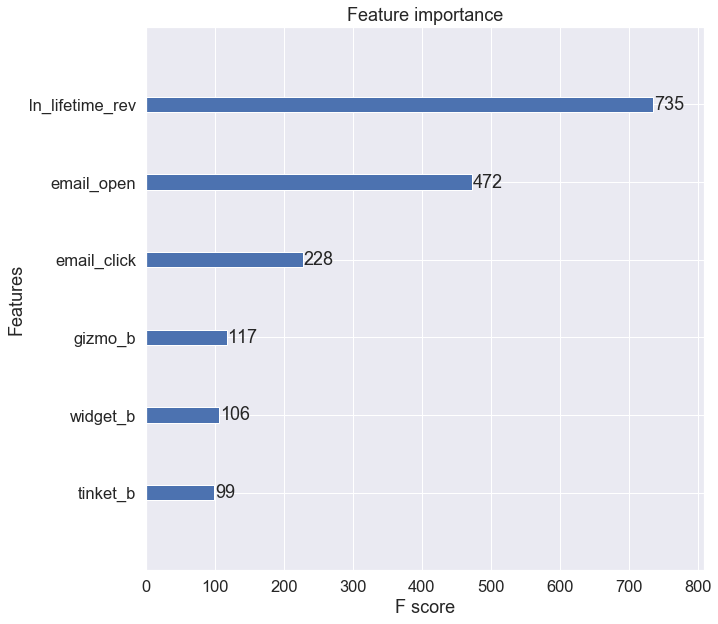

In [32]:
xgb.plot_importance(xg_reg)
plt.savefig('plots/importance')
plt.show()

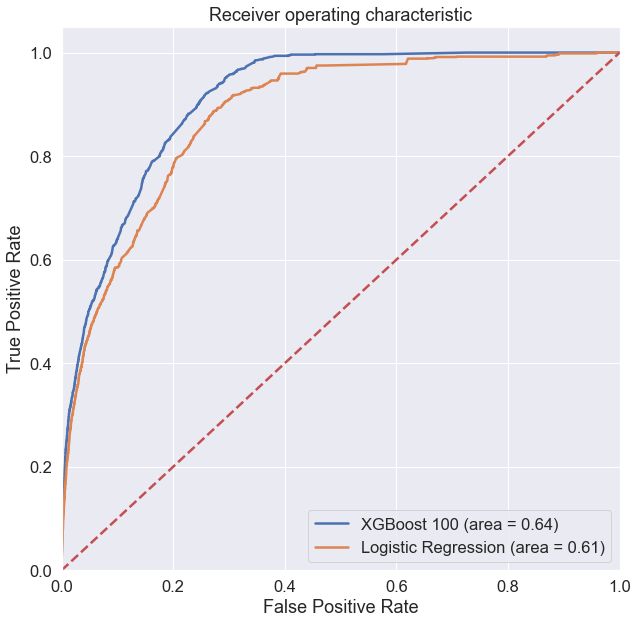

In [31]:
tree_roc_auc = roc_auc_score(Y_test, np.rint(y_pred))
logit_roc_auc = roc_auc_score(Y_test, lreg.predict(X_test))
fpr_l, tpr_l, thresholds_l = roc_curve(Y_test, lreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost 100 (area = %0.2f)' % tree_roc_auc)
plt.plot(fpr_l, tpr_l, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('plots/Log_ROC')
plt.show()

# Revenue Per Order

- Below we spend some time modeling revenue per order

- We find this to be much more straighforward, and as such we spend less time modeling this values




In [135]:
X = engagement[engagement['Revenue_Sum']>0][['ln_lifetime_rev', 'email_interaction', 'widget_b', 
                                            'tinket_b', 'gizmo_b']]
Y = np.log(engagement[engagement['Revenue_Sum']>0]['Revenue_Sum'])

model = OLS(Y,X)

result = model.fit()

result.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>       <td>Revenue_Sum</td>   <th>  R-squared:         </th> <td>   0.953</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.953</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>1.657e+04</td>
</tr>
<tr>
  <th>Date:</th>             <td>Thu, 08 Nov 2018</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>18:58:47</td>     <th>  Log-Likelihood:    </th> <td> -4905.7</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>  4102</td>      <th>  AIC:               </th> <td>   9821.</td> 
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  4097</td>      <th>  BIC:               </th> <td>   9853.</td> 
</tr>
<tr>
  <th>Df Model:</th>              <td>     5</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
          <td></td>             <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ln_lifetime_rev</th>   <td>    0.4450</td> <td>    0.004</td> <td>  101.316</td> <td> 0.000</td> <td>    0.436</td> <td>    0.454</td>
</tr>
<tr>
  <th>email_interaction</th> <td>   -0.2757</td> <td>    0.026</td> <td>  -10.639</td> <td> 0.000</td> <td>   -0.327</td> <td>   -0.225</td>
</tr>
<tr>
  <th>widget_b</th>          <td>   -0.4073</td> <td>    0.036</td> <td>  -11.276</td> <td> 0.000</td> <td>   -0.478</td> <td>   -0.336</td>
</tr>
<tr>
  <th>tinket_b</th>          <td>   -0.6210</td> <td>    0.028</td> <td>  -22.149</td> <td> 0.000</td> <td>   -0.676</td> <td>   -0.566</td>
</tr>
<tr>
  <th>gizmo_b</th>           <td>    0.1145</td> <td>    0.028</td> <td>    4.164</td> <td> 0.000</td> <td>    0.061</td> <td>    0.168</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>379.970</td> <th>  Durbin-Watson:     </th> <td>   1.971</td> 
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td>  <th>  Jarque-Bera (JB):  </th> <td> 492.025</td> 
</tr>
<tr>
  <th>Skew:</th>          <td> 0.842</td>  <th>  Prob(JB):          </th> <td>1.44e-107</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 3.203</td>  <th>  Cond. No.          </th> <td>    30.3</td> 
</tr>
</table><br/><br/>Warnings:<br/>[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [145]:
X = engagement[engagement['Revenue_Sum']>0][['ln_lifetime_rev']]
Y = np.log(engagement[engagement['Revenue_Sum']>0]['Revenue_Sum'])

model = OLS(Y,X)

result = model.fit()

result.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>       <td>Revenue_Sum</td>   <th>  R-squared:         </th> <td>   0.945</td> 
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>   0.945</td> 
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>7.048e+04</td>
</tr>
<tr>
  <th>Date:</th>             <td>Thu, 08 Nov 2018</td> <th>  Prob (F-statistic):</th>  <td>  0.00</td>  
</tr>
<tr>
  <th>Time:</th>                 <td>19:02:04</td>     <th>  Log-Likelihood:    </th> <td> -5222.1</td> 
</tr>
<tr>
  <th>No. Observations:</th>      <td>  4102</td>      <th>  AIC:               </th> <td>1.045e+04</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>  4101</td>      <th>  BIC:               </th> <td>1.045e+04</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     1</td>      <th>                     </th>     <td> </td>    
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>    
</tr>
</table>
<table class="simpletable">
<tr>
         <td></td>            <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ln_lifetime_rev</th> <td>    0.3609</td> <td>    0.001</td> <td>  265.480</td> <td> 0.000</td> <td>    0.358</td> <td>    0.364</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>392.092</td> <th>  Durbin-Watson:     </th> <td>   1.988</td> 
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td>  <th>  Jarque-Bera (JB):  </th> <td> 502.130</td> 
</tr>
<tr>
  <th>Skew:</th>          <td> 0.847</td>  <th>  Prob(JB):          </th> <td>9.20e-110</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 2.742</td>  <th>  Cond. No.          </th> <td>    1.00</td> 
</tr>
</table><br/><br/>Warnings:<br/>[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

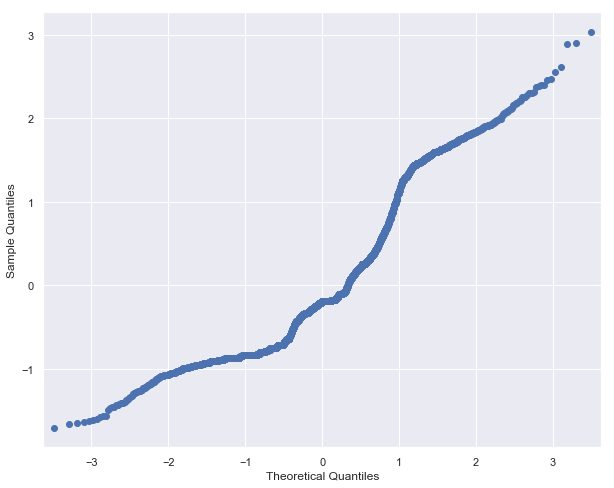

In [146]:
res = result.resid # residuals
fig = sm.qqplot(res)
plt.show()

# Appendix / Appendix Plots

We plot some of the remaining relationships in the data that did not yield anything of note below. 
We found no significant time seasonality in orders or density in order type by time. 

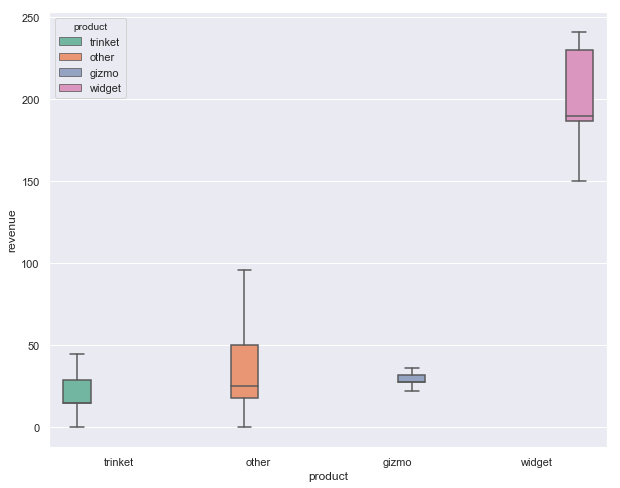

In [48]:
sns.boxplot(x="product", y='revenue', 
                      data=orders,
                      hue = 'product',
                      palette="Set2",
                      showfliers=False)

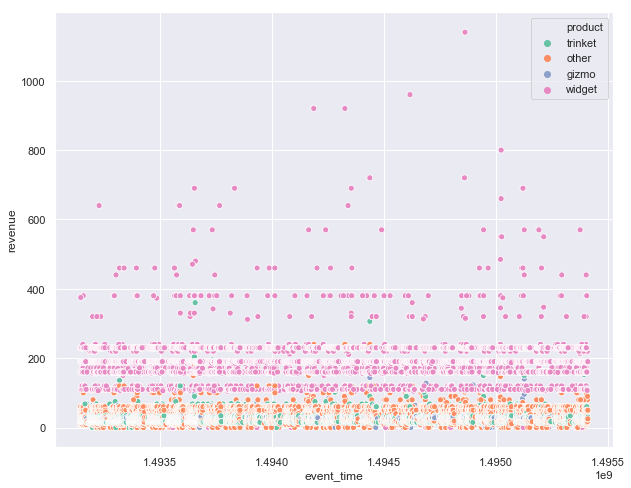

In [30]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(x="event_time", y="revenue", hue="product",
                data=orders, palette="Set2")

In [26]:
orders.columns

Index(['product', 'event_type', 'event_time', 'id', 'revenue', 'event_time_ts',
       'event_time_weekday', 'event_time_hour', 'event_time_date'],
      dtype='object')

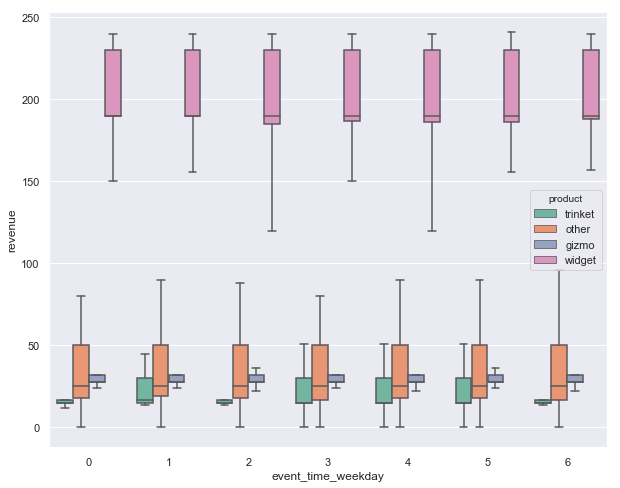

In [49]:
sns.boxplot(x='event_time_weekday', y='revenue', 
                          data=orders,
                          hue = 'product',
                          palette="Set2",
                          showfliers=False)

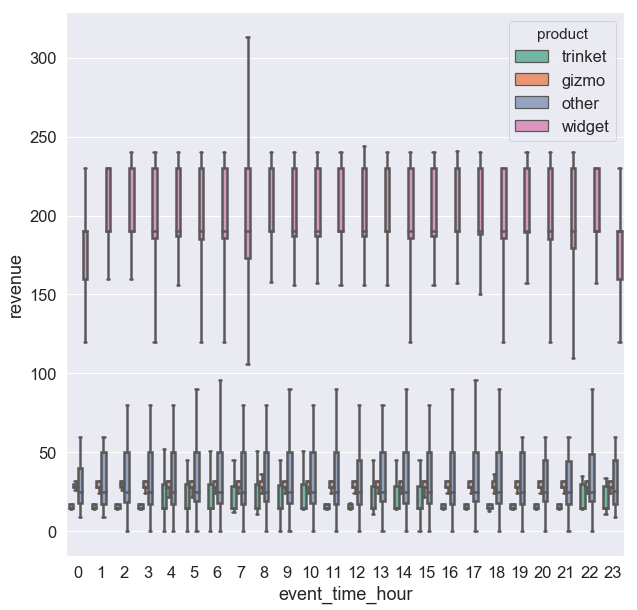

In [84]:
sns.boxplot(x='event_time_hour', y='revenue', 
                          data=orders,
                          hue = 'product',
                          palette="Set2",
                          showfliers=False)